### IMPORTACIÓN DE LIBRERIAS NECESARIAS

In [5]:
import tensorflow as tf
import keras
import numpy as np
import os
import re
import matplotlib.pyplot as plt
%matplotlib inline
import sys
from PIL import Image
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.utils import to_categorical
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU

### IMPORTAR LOS DATOS

Creamos "*directorio*" que es la ruta en la que se encuentran todas las imágenes del proyecto.
Dentro de dicha carpeta se encuentran cuatro carpetas más, una para cada tipo de imagen.

In [6]:
directorio = 'C:/Users/blanca/Desktop/UOC/3º SEMESTRE/TFM/COVID-19_Radiography_Dataset'

A continuación procedemos a cargar las imágenes. Para ello, vamos a utilizar un bucle que itere cada uno de los elementos de nuestro directorio de trabajo. 
Vamos a importar las imágenes de tres formas diferentes:
+ **imagenes**: carga las imágenes con la función load_img() que devuelve una instancia de imagen PIL.
+ **imagenes_array**: carga las imágenes en forma de matriz.
+ **clase**: carga los nombres de cada imagen.


In [ ]:
imagenes = []
clase = []


for root, dirs, files in os.walk(directorio):
    for filename in files:
        img_path = os.path.join(root, filename)
        img = load_img(img_path)
        imagenes.append(img)
    for filename in files:
        clase.append(filename)

### ANÁLISIS EXPLORATORIO DE LOS DATOS

In [4]:
print('Nuestro proyecto está formado por', len(imagenes),'imágenes')

Nuestro proyecto está formado por 21165 imágenes


A continuación mostramos una imagen al azar y su correspondiente etiqueta.

La etiqueta de la imagen nº 10494 es: Normal-1604.png


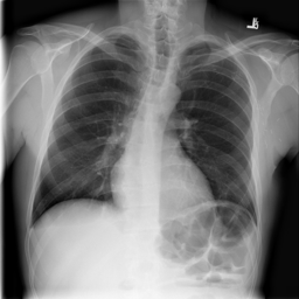

In [5]:
from random import randrange

num_azar = randrange(len(imagenes))
print('La etiqueta de la imagen nº', num_azar, 'es:',clase[num_azar] )
imagenes[num_azar]

Para analizar los datos vamos a crear un data frame formado por las siguientes variables:
+ *Tipo*: nos indica el tipo de imagen.
+ *Size*: nos indica el tamaño de la imagen.
+ *Mode*: nos indica el modo de la imagen.

In [6]:
# Para la variable tipo nos quedaremos únicamente con la parte del
# nombre de la imagen que nos indica su categoría. En este caso es 
# el filename hasta el signo '-'.
Tipo = []
for filenames in clase:
    x = filenames.split(sep ='-')
    x = x[0]
    Tipo.append(x) 

# Creamos las variables Size y Mode accediendo a los atributos que 
# nos aporta una imagen en formato PIL.
Size = []
for i in imagenes:
    x = i.size
    Size.append(x)

Mode = []
for i in imagenes:
    Mode.append(i.mode)

Finalmente crearemos nuestro **data frame** con la función pd.DataFrame de la librería *pandas*, al que llamaremos _df_.

In [7]:
df = pd.DataFrame({
    "Tipo" : Tipo,
    "Size" : Size,
    "Mode" : Mode })

Mostramos el data frame creado:

In [8]:
print(df)

                  Tipo        Size Mode
0                COVID  (299, 299)  RGB
1                COVID  (299, 299)  RGB
2                COVID  (299, 299)  RGB
3                COVID  (299, 299)  RGB
4                COVID  (299, 299)  RGB
...                ...         ...  ...
21160  Viral Pneumonia  (299, 299)  RGB
21161  Viral Pneumonia  (299, 299)  RGB
21162  Viral Pneumonia  (299, 299)  RGB
21163  Viral Pneumonia  (299, 299)  RGB
21164  Viral Pneumonia  (299, 299)  RGB

[21165 rows x 3 columns]


Observamos la información que nos proporciona nuestros data frame.

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21165 entries, 0 to 21164
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Tipo    21165 non-null  object
 1   Size    21165 non-null  object
 2   Mode    21165 non-null  object
dtypes: object(3)
memory usage: 496.2+ KB


Observamos como las tres variables o columnas son de tipo *object*. Ninguna de ella tiene valores faltantes y todas están formadas por 21165 imágenes.

In [10]:
clases = np.unique(Tipo)
nclases = len(clases)
print('Las imágenes pueden ser de',nclases, 'clases, que son las siguientes:', clases)

Las imágenes pueden ser de 4 clases, que son las siguientes: ['COVID' 'Lung_Opacity' 'Normal' 'Viral Pneumonia']


In [11]:
print('El modo de las imágenes puede ser',np.unique(Mode),'y el tamaño de las imágenes puede ser de:',np.unique(Size))

El modo de las imágenes puede ser ['RGB'] y el tamaño de las imágenes puede ser de: [299]


Obtenemos que todas las imágenes tienen el mismo modo y el mismo tamaño. 

Observamos cuantas imágenes tenemos para cada clase.

In [12]:
df.groupby("Tipo").size()

Tipo
COVID               3616
Lung_Opacity        6012
Normal             10192
Viral Pneumonia     1345
dtype: int64

In [13]:
print('En nuestro conjunto de datos observamos como la mayor muestra de imágenes es de tipo Normal con', df.groupby("Tipo").size()[2],'imágenes. Siendo la menor muestra la del grupo de Viral Pneumonia con', df.groupby("Tipo").size()[3],'imágenes.')

En nuestro conjunto de datos observamos como la mayor muestra de imágenes es de tipo Normal con 10192 imágenes. Siendo la menor muestra la del grupo de Viral Pneumonia con 1345 imágenes.


A continuación observamos mediante un gráfico circular el número de imágenes para cada clase. 

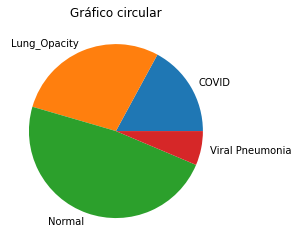

In [14]:
plt.pie(df.groupby("Tipo").size(), labels = clases)
plt.title("Gráfico circular")
plt.show()

### PREPROCESAMIENTO DE LOS DATOS

#### REDUCCIÓN DEL CONJUNTO DE DATOS

In [306]:
import random
from random import sample
import shutil

os.makedirs('/Dataset_reducido', exist_ok = True)

In [307]:
# Establecemos la semilla de pseudoaleatorización
random.seed('123456')

# Creamos las listas 
carpetas = []
clases = []

# Leemos las carpetas de nuestro directorio, hay 4, una por cada clase
for carpeta in os.listdir(directorio):
    # Establecemos la ruta de cada carpeta
    carpeta_path = os.path.join(directorio,carpeta)
    # Juntamos las rutas de las carpetas en la lista *carpetas*
    carpetas.append(carpeta_path)
    
# Leemos cada una de las carpetas que corresponde con cada una de las clases
for carpeta in carpetas:
    # Establecemos el nombre de la carpeta que será el nombre de la clase
    nombre = carpeta.split(sep ='\\')[-1]
    clases.append(nombre)
    
    # Creamos dentro de los directorios Train y Valid las carpetas para cada clase
    os.makedirs('/Dataset_reducido/' + nombre, exist_ok = True)
    
    
    archivos = []
    train_clase = []
    valid_clase = []
    
    # Leemos los archivos (imágenes) de cada carpeta 
    for archivo in os.listdir(carpeta):
        archivos.append(archivo)
        
    # Seleccionamos 1300 imágenes de cada carpeta
    seleccion = sample(archivos, 1300)
    
    # Copiamos las imágenes en sus respectivas carpetas
    for imagen in seleccion:
        img_path = os.path.join(carpeta, imagen)
        shutil.copy(img_path, os.path.join('/Dataset_reducido',nombre, imagen))

#### CARGAMOS LAS IMAGENES Y SUS ETIQUETAS EN LISTAS

In [41]:
IMAGENES = []
ETIQUETAS = []


# Leemos los archivos de Train
for root, dirs, files in os.walk('/Dataset_reducido'):
    # Leemos cada imagen
    for filename in files:
        # Obtenemos su ruta
        img_path = os.path.join(root, filename)
        # Cargamos la imagen
        img = load_img(img_path)
        # Incluimos la imagen en su lista 
        IMAGENES.append(img)
        
        # Obtenemos la etiqueta de cada imagen según su nombre
        x = filename.split(sep ='-')
        x = x[0]
        # Añadimos la clase a la lista de labels
        ETIQUETAS.append(x)

In [42]:
print(len(IMAGENES))
print(len(ETIQUETAS))

5200
5200


#### FUNCIÓN  PARA EL PREPROCESAMIENTO DE LAS IMÁGENES

In [43]:
def preprocesamiento(img):
    # Modo RGB
    if img.mode != 'RGB':
         img = img.convert('RGB')
    # Transformamos la imagen en una matriz de píxeles
    img_array = img_to_array(img)
    
    # Redimensionamos las imágenes
    if img.size != (150, 150):
        img_array = tf.image.resize(img_array, (150, 150))
    # Normalizamos los píxeles
    img_norm = img_array/255
    
    return img_norm

Aplicamos el preprocesamiento a todas nuestras imágenes

In [44]:
x = []
for imagen in IMAGENES:
    img_preprocesada = preprocesamiento(imagen)
    x.append(img_preprocesada)

#### CODIFICACIÓN DE LA VARIABLE CLASE

Continuaremos codificando las clases, es decir, asignando a cada clase un valor numérico. Para ello, crearemos un diccionario que asigne a cada clase un número.

In [311]:
# Visualizamos el nombre de las clases:
set(ETIQUETAS)

{'COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia'}

In [45]:
# Creamos un diccionario
dic = {'COVID':0, 'Lung_Opacity':1, 'Normal':2, 'Viral Pneumonia': 3}

In [46]:
# Asignamos a cada clase de **y** su valor numérico según el diccionario creado
y = [dic.get(n, n) for n in ETIQUETAS]

In [314]:
# Comprobamos las nuevas clases:
set(ETIQUETAS)

{0, 1, 2, 3}

#### TRANSFORMAMOS LAS LISTAS DE IMÁGENES Y ETIQUETAS EN VECTORES

In [47]:
x = np.array(x)
y = np.array(y)

In [48]:
len(x)

5200

#### CREACIÓN DE LOS CONJUNTOS DE ENTRENAMIENTO, PRUEVA Y VALIDACIÓN

Destinaremos el 80% de las imágenes para el *training* o entrenamiento y el 20% para el *test*. De las imágenes destinadas al entrenamiento, cogeremos el 20% para la *validación*.
Para dividir los conjuntos usaremos la función **train_test_split()** de *keras*.

In [49]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.2)

In [50]:
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size = 0.2)

In [51]:
print('Data training', 'Imágenes:',x_train.shape, 'Etiquetas:',y_train.shape)
print('Data test', 'Imágenes:', x_test.shape, 'Etiquetas:',y_test.shape)
print('Data valid', 'Imágenes:', x_valid.shape, 'Etiquetas:',y_valid.shape)

Data training Imágenes: (3328, 150, 150, 3) Etiquetas: (3328,)
Data test Imágenes: (1040, 150, 150, 3) Etiquetas: (1040,)
Data valid Imágenes: (832, 150, 150, 3) Etiquetas: (832,)


#### ONE-HOT ENCODING

Vamos a realizar un one-hot encoding de la variable clase. Esto trata en convertir las etiquetas, es decir, nuestras clases, en una clasificación binaria con 0 y 1. Con ello, se pretende facilitar el rendimiento y funcionamiento de la red neuronal. Se utilizará la función to_categorical() de keras.

In [52]:
from keras.utils import to_categorical

# Hacemos one-hot encoding de las clases 

y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)
y_valid_one_hot = to_categorical(y_valid)

print('Etiqueta original:', y_train[2241], ', Etiqueta one-hot encoding:', y_train_one_hot[2241])

Etiqueta original: 3 , Etiqueta one-hot encoding: [0. 0. 0. 1.]


In [53]:
x_train[1].shape

(150, 150, 3)

# RED NEURONAL DESDE CERO

Crearemos una red con 4 capas de convolución. La función de activación en cada capa es *ReLu*. En cada capa se realizará un **MaxPoling de 2x2** para reducir la imagen manteniendo las características únicas que detectó cada kernel.
A continuación se añade una capa **Flatten()** aplana las características en un vector unidemensional. 


In [54]:
model_A = Sequential()

model_A.add(Conv2D(32, (3, 3), input_shape=(150, 150, 3), activation = 'relu'))
model_A.add(MaxPooling2D(pool_size=(2, 2)))

model_A.add(Conv2D(64, (3, 3), activation = 'relu'))
model_A.add(MaxPooling2D(pool_size=(2, 2)))

model_A.add(Conv2D(128, (3, 3), activation = 'relu'))
model_A.add(MaxPooling2D(pool_size=(2, 2)))

model_A.add(Conv2D(512, (3, 3), activation = 'relu'))
model_A.add(MaxPooling2D(pool_size=(2, 2)))

model_A.add(Flatten()) 

model_A.add(Dense(512, activation = 'relu'))

model_A.add(Dropout(0.2))

model_A.add(Dense(4, activation = 'softmax'))

model_A.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 15, 15, 512)      

In [55]:
model_A.compile(loss = keras.losses.categorical_crossentropy, 
                optimizer = keras.optimizers.Adam(),
                metrics = ['accuracy'])

A continuación entrenamos el modelo usando nuestros datos de entrenamiento.

In [327]:
batch_size = 64
history_A = model_A.fit(x_train, y_train_one_hot,
                        batch_size = 64,
                        epochs = 20,
                        steps_per_epoch = len(x_train) // batch_size,
                        verbose = 1,
                        validation_data = (x_valid, y_valid_one_hot),
                        validation_steps = len(x_valid) // batch_size)

Epoch 1/20
52/52 [==============================] - 278s 5s/step - loss: 1.1493 - accuracy: 0.4835 - val_loss: 0.7340 - val_accuracy: 0.6899
Epoch 2/20
52/52 [==============================] - 227s 4s/step - loss: 0.7296 - accuracy: 0.7100 - val_loss: 0.6245 - val_accuracy: 0.7524
Epoch 3/20
52/52 [==============================] - 223s 4s/step - loss: 0.5915 - accuracy: 0.7626 - val_loss: 0.5633 - val_accuracy: 0.7764
Epoch 4/20
52/52 [==============================] - 216s 4s/step - loss: 0.5120 - accuracy: 0.8023 - val_loss: 0.4674 - val_accuracy: 0.8377
Epoch 5/20
52/52 [==============================] - 234s 5s/step - loss: 0.4329 - accuracy: 0.8332 - val_loss: 0.4588 - val_accuracy: 0.8365
Epoch 6/20
52/52 [==============================] - 227s 4s/step - loss: 0.4303 - accuracy: 0.8362 - val_loss: 0.4041 - val_accuracy: 0.8486
Epoch 7/20
52/52 [==============================] - 218s 4s/step - loss: 0.3701 - accuracy: 0.8534 - val_loss: 0.4069 - val_accuracy: 0.8666
Epoch 8/20
52

In [328]:
model_A.save('model_A.h5')

In [329]:
test_eval = model_A.evaluate(x_test,y_test_one_hot, verbose = 1)

33/33 [==============================] - 19s 582ms/step - loss: 0.7734 - accuracy: 0.8337


No handles with labels found to put in legend.


<Figure size 432x288 with 0 Axes>

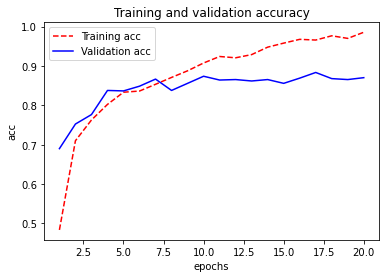

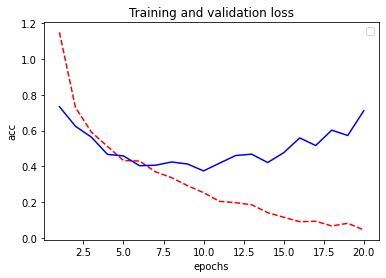

<Figure size 432x288 with 0 Axes>

In [340]:
acc      = history_A.history['accuracy']
val_acc  = history_A.history['val_accuracy']
loss     = history_A.history['loss']
val_loss = history_A.history['val_loss']

epochs   = range(1,len(acc)+1,1)

plt.plot ( epochs,     acc, 'r--', label='Training acc'  )
plt.plot ( epochs, val_acc,  'b', label='Validation acc')
plt.title ('Training and validation accuracy')
plt.ylabel('acc')
plt.xlabel('epochs')

plt.legend()
plt.figure()

plt.plot ( epochs,     loss, 'r--' )
plt.plot ( epochs, val_loss ,  'b' )
plt.title ('Training and validation loss'   )
plt.ylabel('acc')
plt.xlabel('epochs')

plt.legend()
plt.figure()